# Analyze the 1000 Genome Mosaic Outputs
Idea: Analyse a large number of samples together, and prepare summary plots.

This codes assumes that the Simulation as well as the HMM Calling has been done, and that the files have been saved according to the guidelines. This code here loads these files, post-process them and provides summary level statistics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import socket
import os as os
import sys as sys
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)
if socket_name == "VioletQueen":
    path = "/home/harald/git/HAPSBURG/"   # The Path on Harald's machine
elif socket_name.startswith("midway2"):
    print("Midway jnovmbre partition detected.")
    path = "/project2/jnovembre/hringbauer/HAPSBURG/"  # The Path on Midway Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")
    
os.chdir(path)  # Set the right Path (in line with Atom default)

sys.path.append("./Python3/")  # Since now we are in the Root Directory
from hmm_inference import HMM_Analyze   # Do not move. Should be after sys.path..
#sys.path.append("./Python3/create1000G_Mosaic/")  # Since now we are in the Root Directory
#from createMosaicsMulti import Mosaic_1000G_Multi  # Import the object that can create the Multiruns

print(os.getcwd()) # Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(f"CPU Count: {mp.cpu_count()}")

midway2-0401.rcc.local
Midway jnovmbre partition detected.
/project2/jnovembre/hringbauer/HAPSBURG
CPU Count: 28


# Pre-Process

## First some Functions to Load and Pre-process the data

In [2]:
#############################################
### Wrapper Classes to Load the ROH Data
### Could Move to Python Code eventually (to keep loading and plotting seperate)

class Summary_ROH_Calls(object):
    """Class to Provide Summary statistics for multiple replicate Runs"""
    mosaic_folder = "../../Simulated/1000G_Mosaic/TSI/"
    output_prefix = ""
    ch=3 ### Which Chromosome to 
    nr_iid = 20 # How many Individuals were simulated
    blen_cm = 1 # The Length of the Block to analyze
    error=0.0   # For the Subclasses
    missing=0 # For the Subclasses
    output = 1 # The Level of output. 0 None, 1 All,

    def __init__(self, mosaic_folder, ch=3, nr_iid = 20, blen_cm = 1, output_prefix = "", error=0, missing=0, output=0):
        """Initialize the whole Class"""
        self.mosaic_folder = mosaic_folder
        self.ch = ch
        self.blen_cm = blen_cm
        self.nr_iid = nr_iid
        self.output_prefix = output_prefix
        self.output=output
        self.error=error
        self.missing=missing

    def provide_iid_folders(self):
        """Return a list of folders into which replicate simulations are saved into
        folder: Full folder of the analysis
        ch: Which Chromosome was analyzed
        nr_iid: How many replicate Individual were produced
        bl_cm: The length of the analyzed block class in cM
        output_prefix: Prefix before the File
        mode: Which Folder Mode to load. 0: Standard 1: Error Folders 2: Missing Folders"""
        folder, ch, nr_iid, blen_cm, output_prefix = self.mosaic_folder, self.ch,  self.nr_iid, self.blen_cm, self.output_prefix
        
        path_1 = "ch" + str(ch) + "_" + str(int(blen_cm)) + "cm/output/"  # The first part of the Path
        path_2 = "/chr" + str(ch) + "/" + output_prefix # The last part of the Path (within the folder)
        iid_list = ["iid" + str(i) for i in range(nr_iid)]  # The middle parts of the path

        full_paths = [(folder + path_1 + str(i) + path_2)  for i in iid_list]
        return full_paths
    
    def collect_power_df(self):
        """Create and return the Dataframe with the Power.
        Check every simulated block for overlap.
        mode: 0: Standard. 1: Error Folders. 2: Missing Folders"""
                
        folders = self.provide_iid_folders()   # Load all the folders
        df_calls = []

        n_call, n_sim = 0, 0  # Number of total called blocks and simulated blocks
        for f in folders:   
            df_o = load_observed(f)   # Loading should throw error if not existend
            df_s = load_simulated(f)

            n_call += len(df_o)
            n_sim += len(df_s)

            df_call = check_obs_vrs_sim(df_o, df_s)
            df_calls.append(df_call)

        df_calls = pd.concat(df_calls)   # Concatenate all the Results

        if self.output==1:
            print(f"Total Nr Simulated: {n_sim}")
            print(f"Total Nr Called: {n_call}")
            
        return df_calls

    def collect_fp_df(self):
        """Collect and return the Dataframe with the false positive Calls"""
        folders = self.provide_iid_folders()   # Load all the folders
        observed_dfs = [load_observed(f) for f in folders]
        df_observed = pd.concat(observed_dfs)
        return df_observed
    
    #########################################
    ### Give back arrays of information, needed for plots and analysis of multiple folders
    
    def give_power_dfs(self, bl_lens, ovlp_frac=0.8):
        """Load the Power dfs for vector of Block Lengths bl_lens
        bl_lens: Array with length of Blocks
        Return list of dataframes of all blocks, list of dataframe of all called blocks, and list of power"""
        mosaic_folder, output_prefix = self.mosaic_folder, self.output_prefix
        
        df_call_vec = []
        
        for l in bl_lens:
            self.blen_cm = l
            df_call_vec.append(self.collect_power_df())
            
        # Post -Process
        powers = [calc_power(df, ovlp_frac=ovlp_frac) for df in df_call_vec]   # Calculate the Power per Block Length
        df_called = [return_calls_only(df) for df in df_call_vec]   # Only Keep the called blocks for plotting
        return df_call_vec, df_called, powers
    
#############################################
    
class Summary_ROH_Calls_Error(Summary_ROH_Calls): 
    """Same as Summary Calls but with updated folder function"""
    error = 0
    
    def provide_iid_folders(self):
        """Return a list of folders into which replicate simulations are saved intos"""
        folder, ch, nr_iid, blen_cm, output_prefix = self.mosaic_folder, self.ch,  self.nr_iid, self.blen_cm, self.output_prefix
        error = self.error

        e_print = str(round(error, 4)).split(".")[1] # Extract four digits after decimal 
        path_1 = "ch" + str(ch) + "_" + str(int(blen_cm)) + "cm/error/" + e_print + "/output/"  # The first part of the Path
        path_2 = "/chr" + str(ch) + "/" + output_prefix # The last part of the Path (within the folder)
        iid_list = ["iid" + str(i) for i in range(nr_iid)]  # The middle parts of the path

        full_paths = [(folder + path_1 + str(i) + path_2)  for i in iid_list]
        return full_paths
    
#############################################
    
class Summary_ROH_Calls_Missing(Summary_ROH_Calls):
    """Same as Summary Calls but with updated folder function"""
    
    def provide_iid_folders(self):
        """Return a list of folders into which replicate simulations are saved intos"""
        folder, ch, nr_iid, blen_cm, output_prefix = self.mosaic_folder, self.ch,  self.nr_iid, self.blen_cm, self.output_prefix
        missing = self.missing
        m_print = str(round(missing, 4)).split(".")[1] # Extract four digits after decimal 
        path_1 = "ch" + str(ch) + "_" + str(int(blen_cm)) + "cm/missing/" + m_print + "/output/"  # The first part of the Path
        path_2 = "/chr" + str(ch) + "/" + output_prefix # The last part of the Path (within the folder)
        iid_list = ["iid" + str(i) for i in range(nr_iid)]  # The middle parts of the path
        full_paths = [(folder + path_1 + str(i) + path_2)  for i in iid_list]
        return full_paths

#############################################
#############################################
### Various Helper Functions for Analysis

def load_observed(path, file="roh.csv"):
    """ Load simulated Dataframe from path"""
    df = pd.read_csv(path + file, sep=",")  # Load the Meta File
    return df

def load_simulated(path, file="roh_gt.csv"):
    """ Load Ground Truth Dataframe from path"""
    df = pd.read_csv(path + file, sep="\t")  # Load the Meta File
    return df

def find_overlap(l, min_l, max_l):
    """ Find overlap of Interval l with intervals starting at min_l and ending at max_l
    Return max overlap as well as Block length (or 0, 0 if no overlap)
    l: Interval [Length 2 list]
    min_l: Minimum Interval Lengths
    max_l: Maximum Interval Lengths"""
    assert(len(l)==2)
    assert(len(min_l) == len(max_l))

    if len(min_l)==0: # If no interval given return 0 Overlap 0 total Length
        return 0, 0

    min_both = np.maximum(l[0], min_l)
    max_both = np.minimum(l[1], max_l)  
    overlap = max_both - min_both   # Calculate the Overlap

    i = np.argmax(overlap)
    max_overlap = overlap[i]

    if max_overlap < 0:
        return 0., 0.   # Return 0 Overlap and 0 total length

    else:
        orginal_length = max_l[i] - min_l[i]
        return max_overlap, orginal_length


def check_obs_vrs_sim(df_o, df_s):
    """Analyze observed . 
    Input: 2 Dataframes
    Output: 1 Dataframe
    Return: One dateframe with intersecting [Overlap, CalledLength, Originallength, Position]"""
    begin_obs = df_o["StartM"].values * 100  # Factor 100: To do everything in centiMorgan
    end_obs = df_o["EndM"].values * 100

    overlaps = np.zeros(len(df_s))
    lengths = np.zeros(len(df_s))

    for i, row in df_s.iterrows():
        roh = [row["ROH_Begin"] * 100, row["ROH_End"] * 100]
        ovlp, lgth = find_overlap(roh, begin_obs, end_obs)  # Find the Overlap

        overlaps[i] = ovlp
        lengths[i] = lgth

    org_lengths = (df_s["ROH_End"] - df_s["ROH_Begin"]) * 100 ### The original Lengths
    ovlp_frac = overlaps / org_lengths ### Fraction of Block called

    df_call = pd.DataFrame({"Overlap": overlaps, "CalledLength":lengths, "OriginalLength": org_lengths,
                            "OverlapFrac": ovlp_frac, "Position": df_s["ROH_Begin"].values * 100, "iid":df_s["iid"]})

    ###  Create df with Original Length, Found Length, Position, Overlap (Fraction)  
    return df_call

#############################################
### Post-Processing the Call Dataframe

def statistics_power_df(df, min_frac=0.8):
    """Report some statistics on the Power Dataframe.
    min_len: Minimum Overlap Length of Block to be counted as a call"""
    l = len(set(df["iid"]))
    no_calls = df["Overlap"]<0.01
    df_c = df[~no_calls]  # The Dataframe with the lenghts called
    mean_called = np.mean(df_c["CalledLength"])
    good_call_nr = np.sum(df["OverlapFrac"] > min_frac)

    print(f"{l} unique Individuals")
    print(f"{len(df) - np.sum(no_calls)} / {len(df)} Blocks called")
    print(f"{good_call_nr} Blocks called > {min_frac*100} %")
    print(f"{mean_called:.4f} average Block Length cM (called)")

def calc_power(df, ovlp_frac=0.8):
    """Calculate and return the Power from the Calling Dataframe"""
    no_calls = np.sum(df["OverlapFrac"] < ovlp_frac)
    power = 1  - (no_calls / len(df))
    return power

def give_SE(df):
    """Calculate and return Standard Deviation (and maybe quartiles) [in cM]"""
    s = np.std(df["CalledLength"].values)
    return s

def give_bias(df, true_lgth):
    """Calculate and return the bias of estimates.
    true_length: Length of simulated blocks [in cM]"""
    b = np.mean(df["CalledLength"].values) - true_lgth
    return b

def return_calls_only(df, ovlp=0.01):
    """Return Dataframe of only called Blocks"""
    no_calls = df["Overlap"]<ovlp
    df_c = df[~no_calls]  # The Dataframe with the lenghts called
    return(df_c)

def false_power_statistics(df):
    '''Report some statistics on the false Power Dataframe'''
    bl_lens = df["lengthM"].values


    print(f"Found {len(bl_lens)} FP blocks")
    if len (bl_lens)>0:
        print(f"Average Block length: {np.mean(bl_lens):.4f} cM")
        print(f"Maximum Block length: {np.max(bl_lens):.4f} cM")
        
def false_positive_nrs(df_call_fp, pw_lens):
    """For list pw_lens (in cM) return the number of blocks longer than each of that
    Return array of integers, same in size as pw_lens"""
    lengths = df_call_fp["lengthM"] * 100
    powers = [np.sum(lengths>l) for l in pw_lens]
    return np.array(powers) 

### Statistics of single Run (for single block length)

In [4]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 6, 
                        output_prefix = "plink/", output=1, error=0.001)
df_calls = roh.collect_power_df()
statistics_power_df(df_calls)
calc_power(df_calls)
give_SE(df_calls)

Total Nr Simulated: 500
Total Nr Called: 1674
100 unique Individuals
500 / 500 Blocks called
490 Blocks called > 80.0 %
6.0762 average Block Length cM (called)


0.35407574838889255

In [11]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 10, 
                        output_prefix = "bcftools/", output=1, error=0.001)
df_calls = roh.collect_power_df()
statistics_power_df(df_calls)
calc_power(df_calls)
give_SE(df_calls)

Total Nr Simulated: 500
Total Nr Called: 3026
100 unique Individuals
500 / 500 Blocks called
500 Blocks called > 80.0 %
10.0726 average Block Length cM (called)


0.14170384073129116

In [29]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/lambda_rc0.5/", ch=3, nr_iid = 100, blen_cm = 0, 
                        output_prefix = "bcftools100/", output=1, error=0.001)
df_calls = roh.collect_power_df()
statistics_power_df(df_calls)
calc_power(df_calls)
give_SE(df_calls)

Total Nr Simulated: 0
Total Nr Called: 6
0 unique Individuals
0 / 0 Blocks called
0 Blocks called > 80.0 %
nan average Block Length cM (called)


/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:221: RuntimeWarning: invalid value encountered in long_scalars
/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/software/python-3.7.0-el7-x86_64/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan

### With Error Loading

In [8]:
roh = Summary_ROH_Calls_Error(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, 
                              blen_cm = 2, output_prefix = "", output=1, error=0.001)
df_calls = roh.collect_power_df()
statistics_power_df(df_calls)
calc_power(df_calls)

Total Nr Simulated: 500
Total Nr Called: 557
100 unique Individuals
497 / 500 Blocks called
464 Blocks called > 80.0 %
2.0361 average Block Length cM (called)


0.928

In [24]:
bl_lens = [2, 4, 6, 8, 10]   # The Length of the Blocks


### Extract the Pandas Dataframes for called blocks
df_call_vec = [collect_power_df(mosaic_folder = "../../Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = l, output_prefix="ROHin10/") 
            for l in bl_lens]

powers = [calc_power(df) for df in df_call_vec]   # Calculate the Power per Block Length
df_call_vec1 = [return_calls_only(df) for df in df_call_vec]   # Only Keep the called blocks for plotting


###########################
ses = [give_SE(df) for df in df_call_vec1]
bias = [give_bias(df_call_vec1[i], bl_lens[i]) for i in range(len(bl_lens))]

print("Standard Errors:")
print(ses)

print("Biases:")
print(bias)

Standard Errors:
[0.42333273924268167, 0.4781977540482479, 0.3757196592178983, 0.47278934045834486, 0.44050553775379375]
Biases:
[0.19401742399999877, 0.18881508799999924, 0.16879123799999984, 0.21679731800000113, 0.15682484400000085]


# Figures

## Power Plot

In [3]:
def plot_power(bl_lens, df_call_vec1, powers, fs = 12, fs_l=12, xlim=(0,12.5), figsize=(10,6), n=100, savepath="", title=""):
    """ bl_lens: Array of Block Lengths
        df_call_vec1: Array of Called Blocks
        powers: Array of Power to call Blocks
    Load, and plot power and power curves"""
    assert(len(bl_lens)==len(df_call_vec1)==len(powers)) # Sanity Check
        
    ylim_pow =[0.5, 1.05]
    bins = np.linspace(0, 15, 75)  # Bins of 0.1 cM
    
    ### Set Colors
    cmap = cm.get_cmap("viridis_r")
    colors = [cmap(x) for x in np.linspace(0,1, len(bl_lens))]
    
    ####### Do the actual Plot
    plt.figure(figsize=figsize)

    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 4])
    gs.update(hspace=0.04) # set the spacing between axes. 

    ax = plt.subplot(gs[1]) # The lower subplot
    ax1 = plt.subplot(gs[0]) # The upper subplot

    # Plot All Histograms
    for i in range(len(bl_lens)):
        l = bl_lens[i]
        ax.hist(df_call_vec1[i]["CalledLength"], bins = bins, color = colors[i], alpha=0.9, label= str(l) + " cM", ec="silver")
        ax.axvline(l, color = "gray", linewidth=2)

    ax.set_xlim(xlim)
    ax.set_xlabel("Inferred block Length [cM]", fontsize = fs)
    ax.set_ylabel("Inferred ROH length", fontsize = fs)
    ax.legend(loc = "upper right", fontsize = fs_l, title="Simulated ROH")

    ax1.set_ylabel("Called at \n80% overlap", fontsize = fs)
    ax1.set_xticks([])
    ax1.scatter(bl_lens, powers, c=colors, s=100,zorder=1)
    ax1.plot(bl_lens, powers, "gray", zorder=0)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim_pow)

    plt.title(title, fontsize=fs)
    
    if len(savepath) >0:
        plt.savefig(savepath)
    plt.show()

### Example Plot

In [9]:
bl_lens=[2, 4, 6, 8, 10]
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/YRI/", ch=3, nr_iid = 100, blen_cm = 2, output_prefix = "allRef/", output=1)
#roh = Summary_ROH_Calls_Missing(mosaic_folder="./Simulated/1000G_Mosaic/CHB/", ch=3, nr_iid = 100, blen_cm = 2, output_prefix = "", output=1, missing=0.9)
df_call_vec, df_called, power = roh.give_power_dfs(bl_lens)

Total Nr Simulated: 500
Total Nr Called: 534
Total Nr Simulated: 500
Total Nr Called: 546
Total Nr Simulated: 500
Total Nr Called: 530
Total Nr Simulated: 500
Total Nr Called: 529
Total Nr Simulated: 500
Total Nr Called: 536


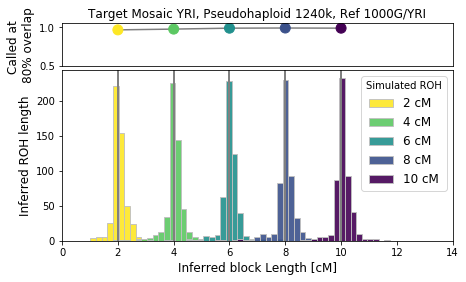

In [11]:
plot_power(bl_lens, df_called, power, title="Target Mosaic YRI, Pseudohaploid 1240k, Ref 1000G/YRI", savepath="", figsize=(7,4), xlim=[0,14])

## False Positive Plot

In [4]:
def plot_fp_distribution(df_call_fp, fs = 14, fs_l = 12, bins = np.linspace(1, 3, 26), xlim = (0, 13), figsize = (10, 4),
                        title = "100 Mosaic Tuscany Samples - Reference: Rest EUR 1000G"):
    """ Plot the Distribution of false positive ROH calls"""

    ### The Actual Plot
    plt.figure(figsize=figsize)

    ax = plt.gca()
    ax.hist(df_call_fp["lengthM"] * 100, bins = bins, color = "green", alpha=0.9, ec="silver")
    ax.set_xlabel("Inferred block Length [cm]", fontsize=fs)
    ax.set_ylabel("Count", fontsize=fs)
    roh1cm = np.sum(df_call_fp["lengthM"]>0.01)
    ax.text(x=0.6, y=0.8, s=f"Tot. #ROH > 1cM: {roh1cm}", transform=ax.transAxes, fontsize=fs)  
    
    plt.title(title, fontsize=fs)
    plt.show()

### Example Application

In [20]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/YRI/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "allRef/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics

Found 0 FP blocks


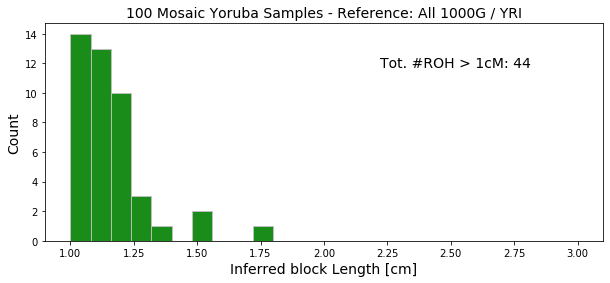

In [14]:
plot_fp_distribution(df_call_fp, title = "100 Mosaic Yoruba Samples - Reference: All 1000G / YRI")

Found 0 FP blocks


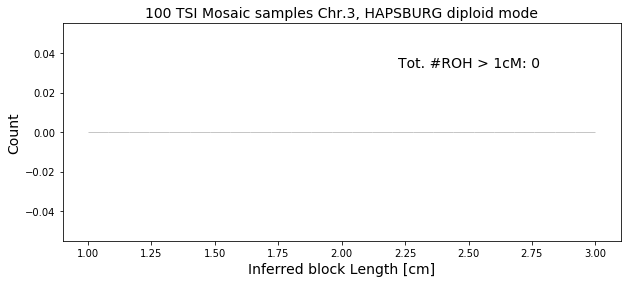

In [27]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "diploidGT/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics
plot_fp_distribution(df_call_fp, title = "100 TSI Mosaic samples Chr.3, HAPSBURG diploid mode")

Found 1361 FP blocks
Average Block length: 0.0029 cM
Maximum Block length: 0.0128 cM


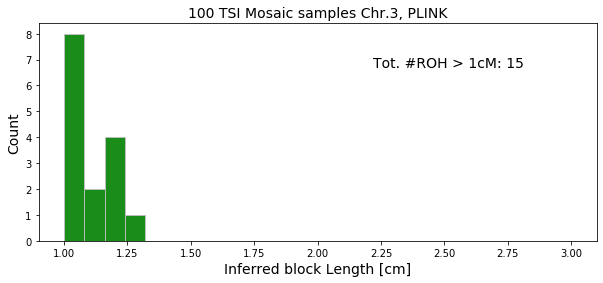

In [28]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "plink/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics
plot_fp_distribution(df_call_fp, title = "100 TSI Mosaic samples Chr.3, PLINK")

Found 3565 FP blocks
Average Block length: 0.0025 cM
Maximum Block length: 0.0150 cM


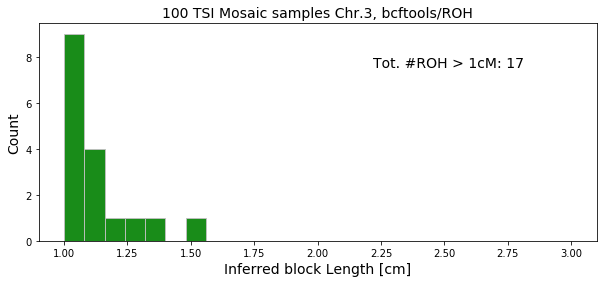

In [31]:
roh = Summary_ROH_Calls(mosaic_folder="./Simulated/1000G_Mosaic/TSI5/", ch=3, nr_iid = 100, blen_cm = 0, output_prefix = "bcftools/")
df_call_fp = roh.collect_fp_df()
false_power_statistics(df_call_fp)  # Do give some written statistics
plot_fp_distribution(df_call_fp, title = "100 TSI Mosaic samples Chr.3, bcftools/ROH")

## Output Full Set of Analysis per Run
Requires all Blocks lengths run for all individuals
Rerun the Cell below

In [5]:
def show_full_results(roh, bl_lens = [2, 4, 6, 8, 10], pw_lens=[1,2,3,4], bl_focus = 4, title=""):
    """Show Full range of results: Statistic for bl_focus, Power Curve for all b_lens, FP-Rate.
    roh: ROH Object, which has the parameters for the folder set
    pw_lens: Lenghts for False Positive cutoffs"""
    
    ###### 1) Do the statistics
    roh.blen_cm = bl_focus
    df_calls = roh.collect_power_df()
    statistics_power_df(df_calls)

    ### Statistics
    df1 = return_calls_only(df_calls)
    ses = give_SE(df1)
    bias = give_bias(df1, bl_focus)

    print(f"Statistics for BL Lengths: {bl_focus}")
    print(f"Standard Error: {ses:.4f}")
    print(f"Bias: {bias:.4f}")
    
    ###### 2) Do the FP Plot:
    roh.blen_cm = 0 # Set to 0
    df_call_fp = roh.collect_fp_df()
    #false_power_statistics(df_call_fp)  # Do give some written statistics
    fp_vec = false_positive_nrs(df_call_fp, pw_lens)
    
    for i in range(len(pw_lens)):
        print(f"FP Blocks > {pw_lens[i]} cM: {fp_vec[i]}")

    ###### 3) Do the Power Plot
    df_call_vec, df_called, power = roh.give_power_dfs(bl_lens)
    plot_power(bl_lens, df_called, power, savepath="", title=title)
    print("Analysis Complete")

Total Nr Simulated: 500
Total Nr Called: 678
100 unique Individuals
500 / 500 Blocks called
489 Blocks called > 80.0 %
4.0695 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.4646
Bias: 0.0695
FP Blocks > 1 cM: 228
FP Blocks > 2 cM: 6
FP Blocks > 3 cM: 2
FP Blocks > 4 cM: 0
Total Nr Simulated: 500
Total Nr Called: 685
Total Nr Simulated: 500
Total Nr Called: 678
Total Nr Simulated: 500
Total Nr Called: 677
Total Nr Simulated: 500
Total Nr Called: 655
Total Nr Simulated: 500
Total Nr Called: 677


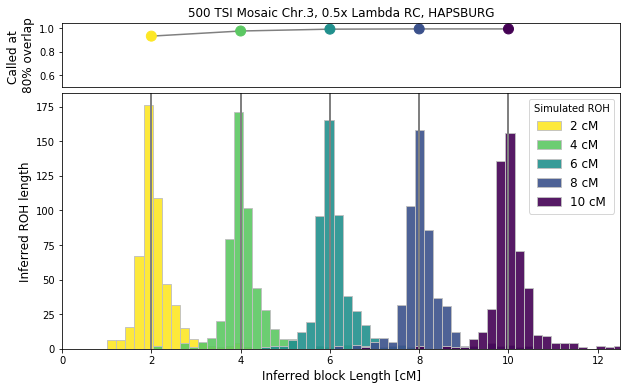

Analysis Complete


In [35]:
output_prefix = "allref/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
#mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc2.0/"
#mosaic_folder = "./Simulated/1000G_Mosaic/CHB/lambda_rc0.5/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc0.5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, title="500 TSI Mosaic Chr.3, 0.5x Lambda RC, HAPSBURG")

In [ ]:
output_prefix = "plink/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, title="500 TSI Mosaic Chr.3, PLINK")

In [ ]:
output_prefix = "bcftools/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, title="500 TSI Mosaic Chr.3, bcftools/ROH")

In [ ]:
output_prefix = "bcftools/"   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" mmr95/ e001/
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/ph1.0/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, 
                        blen_cm = bl_focus, output_prefix = output_prefix, output=1)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus, title="500 TSI Mosaic Chr.3 pseudohaploid, bcftools/ROH")

### Single Parameter Results for Data with error

Showing Results for Error: 0.0268
Total Nr Simulated: 500
Total Nr Called: 558
100 unique Individuals
500 / 500 Blocks called
422 Blocks called > 80.0 %
3.7923 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.6267
Bias: -0.2077


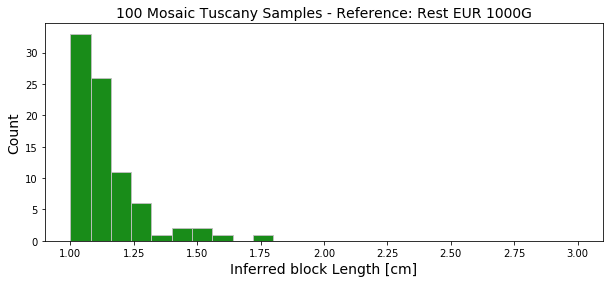

Found 83 FP blocks
Average Block length: 0.0114 cM
Maximum Block length: 0.0179 cM
Total Nr Simulated: 500
Total Nr Called: 550
Total Nr Simulated: 500
Total Nr Called: 558
Total Nr Simulated: 500
Total Nr Called: 574
Total Nr Simulated: 500
Total Nr Called: 575
Total Nr Simulated: 500
Total Nr Called: 592


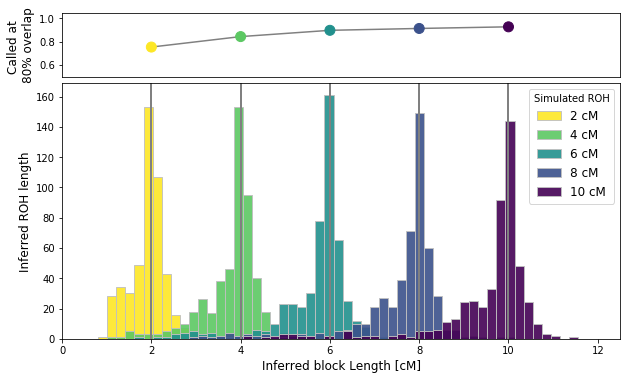

In [79]:
error_vec = np.logspace(-3,-1, 8)
error = error_vec[5]

output_prefix = ""  #"e01/" #"ROHin50/"
mosaic_folder = "./Simulated/1000G_Mosaic/CHB/"

bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

print(f"Showing Results for Error: {error:.4f} \n")
roh = Summary_ROH_Calls_Error(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1, error=error)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus)

### Single Parameter Results for missing data


Showing Results for Missing: 0.5000
Total Nr Simulated: 500
Total Nr Called: 501
100 unique Individuals
500 / 500 Blocks called
497 Blocks called > 80.0 %
3.9754 average Block Length cM (called)
Statistics for BL Lengths: 4
Standard Error: 0.1717
Bias: -0.0246
FP Blocks > 1 cM: 5
FP Blocks > 2 cM: 0
FP Blocks > 3 cM: 0
FP Blocks > 4 cM: 0
Total Nr Simulated: 500
Total Nr Called: 500
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 502
Total Nr Simulated: 500
Total Nr Called: 501
Total Nr Simulated: 500
Total Nr Called: 503


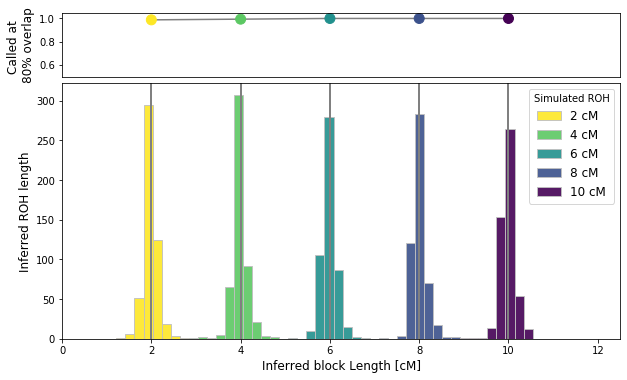

Analysis Complete


In [6]:
missing_vec = np.linspace(0.1, 1.0, 10)
m = missing_vec[4]

output_prefix = "diploidGT/" #"ROHin50/" /diploidGT
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"

bl_lens = [2, 4, 6, 8, 10]
bl_focus = 4 ### Which Statistics to show (when needed)
ch=3
nr_iid=100

print(f"\nShowing Results for Missing: {m:.4f}")

###### Create the Wrapper Object
roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1, missing=m)
show_full_results(roh, bl_lens = bl_lens, bl_focus = bl_focus)

## Plot FP as well as Power at 80 % (4 cM) as function of error

In [4]:
def load_fp_powers_error(roh, error_vec, bl_lens, pw_lens):
    """Load False Positive Rates, as well as Power Curves
    roh: The object to load ROH data
    error_vec: For which errors to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]""" 
    fps = np.zeros(shape=(len(pw_lens), len(error_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(error_vec)), dtype="float") # Empty Array for Power   
    
    for i, error in enumerate(error_vec):
        print(f"Loading data for Error: {error:.4f}")
        roh.error = error
        roh.blen_cm=0  # Collect for bl 0
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers

def load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens):
    """Load False Positive Rates, as well as Power Curves
    roh: The object to load ROH data
    error_vec: For which errors to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    pw_lens: For which Block Lengthss to load Nr > cutoff [l1]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]""" 
    fps = np.zeros(shape=(len(pw_lens), len(missing_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(missing_vec)), dtype="float") # Empty Array for Power   
    
    for i, m in enumerate(missing_vec):
        print(f"Loading data for Missing: {m:.4f}")
        roh.missing = m
        roh.blen_cm=0  # Collect for bl 0
        
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers


def load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "rc", output_prefix="", rd_digs=False):
    """Load False Positive Rates, as well as Power Curves for Different RC data
    base_path: The base path with which various RC 
    rc_vec: For which Readcounts to load the data [e]
    bl_lens: For which Block Lengths to load the data [l]
    pw_lens: For which Block Lengthss to load Nr > cutoff [l1]
    return: 1D array of False Positive Numbers [e], 2D array of Power [l, e]
    rd_digs: Whether to round the rc float to two relevants digits""" 
    fps = np.zeros(shape=(len(pw_lens), len(rc_vec)), dtype="float")  # Empty Array for False positive Rate
    powers = np.zeros(shape=(len(bl_lens), len(rc_vec)), dtype="float") # Empty Array for Power   
    
    for i, rc in enumerate(rc_vec):
        if rd_digs:
            rc = f"{rc:.1f}"
        print(f"Loading data for mean RC: {rc} x")
        folder = base_path + rc_string + str(rc) + "/"
        roh = Summary_ROH_Calls(mosaic_folder=folder, ch=3, nr_iid = 100, blen_cm = 2, output_prefix = output_prefix, output=0)
        roh.blen_cm=0  # Collect for bl 0
        
        df_call_fp = roh.collect_fp_df()
        fps[:,i] = false_positive_nrs(df_call_fp, pw_lens)
        
        _, _, power = roh.give_power_dfs(bl_lens)
        powers[:, i] = power

    print("Successfully loaded complete data!")
    return fps, powers


def plot_fp_power_errors(error_vec, pw_lens, bl_lens, fps, power,
                         title="", savepath="", xlabel="Error Rate Target", xscale="log",
                         leg_loc="lower left", leg_loc1="upper right"):
    """Plot False Positive rates as well as power against different error rates
    error_vec: Vector of Errors
    fps: List of false positive Call Numbers
    power: List of power fractions
    pw_lens: Lengths of the Power Cutoffs
    bl_lens: Lengths of Blocks simulated for power testing"""
    fs = 14
    figsize = (6,6)
    
    ### Set the Colors
    cmap = cm.get_cmap("viridis_r")
    norm = plt.Normalize(1, np.max(bl_lens)) # Do the normalization
    colors = [cmap(norm(x)) for x in bl_lens]
    colors1 = [cmap(norm(x)) for x in pw_lens]

    plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(2, 1, height_ratios=[1, 1])
    gs.update(hspace=0.05) # set the spacing between axes. 

    ax = plt.subplot(gs[0]) # The lower subplot
    ax1 = plt.subplot(gs[1]) # The upper subplot
    
    for i in range(len(bl_lens)):
        ax.plot(error_vec, power[i,:], "o-", color = colors[i], label = f"{bl_lens[i]} cM")
    
    ax.set_ylabel("Fraction called \nwith 80% overlap", fontsize=fs)
    ax.set_xscale(xscale)
    ax.set_xticks([])
    ax.set_ylim([0,1])
    ax.legend(loc = leg_loc, title="Block Length", fontsize=fs*0.8)

    for i in range(len(pw_lens)):
        ax1.plot(error_vec, fps[i,:], "o-", color = colors1[i], label = f"> {pw_lens[i]} cM")
        #ax1.errorbar(error_vec, fps[i,:], yerr=np.sqrt(fps[i,:]))
    ax1.set_ylabel("# False Positives \nper 100 Chr3", fontsize=fs)
    ax1.set_xscale(xscale)
    ax1.set_xlabel(xlabel, fontsize=fs)
    ax1.legend(loc = leg_loc1, title="Block Length", fontsize=fs*0.8)
    
    
    if len(title)>0:  # Set Title if given
        ax.set_title(title, fontsize=fs)
        
    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Successfully saved to {savepath}")

In [11]:
%%time
### Load the Data
error_vec = np.logspace(-3,-1, 8)
output_prefix = "e01/" # "e01/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
ch=3
nr_iid=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called


roh = Summary_ROH_Calls_Error(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_error(roh, error_vec, bl_lens, pw_lens)

Loading data for Error: 0.0010
Loading data for Error: 0.0019
Loading data for Error: 0.0037
Loading data for Error: 0.0072
Loading data for Error: 0.0139
Loading data for Error: 0.0268
Loading data for Error: 0.0518
Loading data for Error: 0.1000
Successfully loaded complete data!
CPU times: user 41 s, sys: 2.91 s, total: 43.9 s
Wall time: 4min 10s


Successfully saved to ./figures_test/power_test_TSI5.pdf


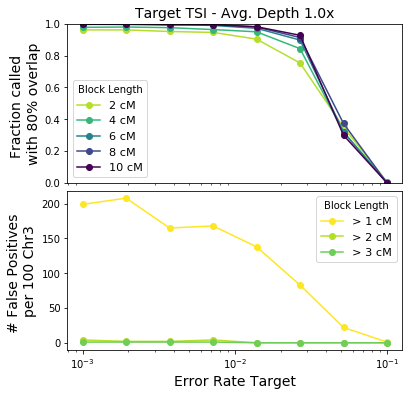

In [15]:
plot_fp_power_errors(error_vec, pw_lens, bl_lens, fps, powers, title="Target TSI - Avg. Depth 1.0x", 
                     savepath="./figures_test/power_test_TSI5.pdf", 
                     xlabel="Error Rate Target", xscale="log")   # "./figures_test/missing_01_powerfp_CHB.pdf" ./figures_test/poisson_rc_summary_2.0-6.0.pdf

# Plot FP as well as 80 % Overlap Power for various Levels of Missingness 

In [15]:
%%time
### Load the Data
missing_vec = np.linspace(0.1, 1.0, 10)
#missing_vec = [0.1, 0.2]
output_prefix = "diploidGT/" # "e01/" "diploidGT/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"  #TSI5 CHB
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
ch=3
n=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = n, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens)

Loading data for Missing: 0.1000
Loading data for Missing: 0.2000
Loading data for Missing: 0.3000
Loading data for Missing: 0.4000
Loading data for Missing: 0.5000
Loading data for Missing: 0.6000
Loading data for Missing: 0.7000
Loading data for Missing: 0.8000
Loading data for Missing: 0.9000
Loading data for Missing: 1.0000
Successfully loaded complete data!
CPU times: user 51.6 s, sys: 3.35 s, total: 54.9 s
Wall time: 5min 20s


Successfully saved to ./figures_test/missing_01_powerfp_TSI_diploidGT.pdf


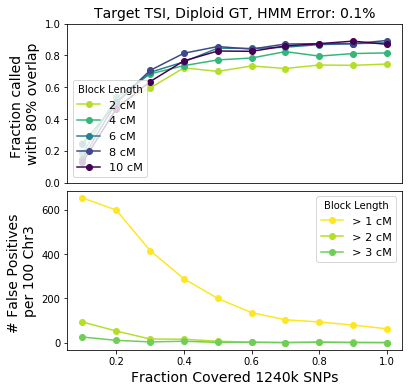

In [13]:
plot_fp_power_errors(missing_vec, pw_lens, bl_lens, fps, powers, title="Target TSI, Diploid GT, HMM Error: 0.1%", savepath="./figures_test/missing_01_powerfp_TSI_diploidGT.pdf", 
                     xlabel="Fraction Covered 1240k SNPs", xscale="linear")   # "./figures_test/missing_01_powerfp_CHB.pdf"

In [12]:
%%time
### Load the Data
missing_vec = np.linspace(0.1, 1.0, 10)
#missing_vec = [0.1, 0.2]
output_prefix = "" # "e01/"
mosaic_folder = "./Simulated/1000G_Mosaic/CHB/"  #TSI5 CHB
bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
ch=3
n=100
min_frac = 0.8 ### Minimum Fraction for Blocks to be called

roh = Summary_ROH_Calls_Missing(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = 0, output_prefix = output_prefix, output=0)
fps, powers = load_fp_powers_missing(roh, missing_vec, bl_lens, pw_lens)

Loading data for Missing: 0.1000
Loading data for Missing: 0.2000
Loading data for Missing: 0.3000
Loading data for Missing: 0.4000
Loading data for Missing: 0.5000
Loading data for Missing: 0.6000
Loading data for Missing: 0.7000
Loading data for Missing: 0.8000
Loading data for Missing: 0.9000
Loading data for Missing: 1.0000
Successfully loaded complete data!
CPU times: user 51.8 s, sys: 3.03 s, total: 54.8 s
Wall time: 4min 28s


In [ ]:
#title = "Target CHB - Lambda RC, HMM Read Error: 1%"
title = "Target CHB - Pseudohaploid, HMM Error: 0.1%"
plot_fp_power_errors(missing_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", xlabel="Coveage 1240k", xscale="linear")

## Plot the curves for Poisson RC data

In [17]:
%%time
rc_vec = np.linspace(0.1, 1, 10)
rc_vec = rc_vec[1:]
#rc_vec0 = np.linspace(2, 6, 5)
#rc_vec = [f"{m_rc:.1f}" for m_rc in rc_vec0]

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
base_path="./Simulated/1000G_Mosaic/CHB/"
output_prefix = "ROH1000/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=True)  # or rc for normal rc

Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.3 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 45.8 s, sys: 2.93 s, total: 48.7 s
Wall time: 3min 26s


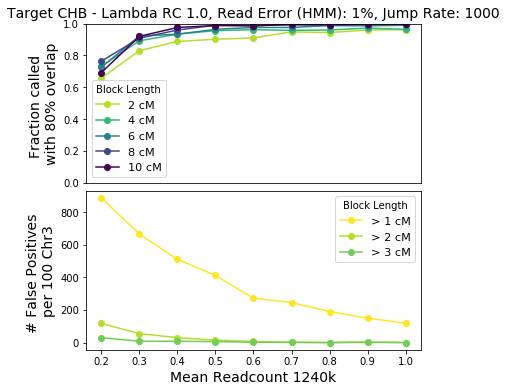

In [22]:
title = "Target CHB - Lambda RC 1.0, Read Error (HMM): 1%, Jump Rate: 1000"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", 
                     xlabel="Mean Readcount 1240k", xscale="linear")   # "./figures_test/missing_01_powerfp_CHB.pdf" ./figures_test/poisson_rc_summary_2.0-6.0.pdf

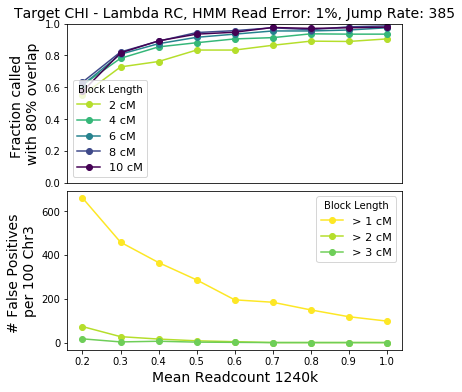

In [11]:
#title = "Target CHB - Lambda RC, HMM Read Error: 1%"
title = "Target CHI - Lambda RC, HMM Read Error: 1%, Jump Rate: 385"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", 
                     xlabel="Mean Readcount 1240k", xscale="linear")   # "./figures_test/missing_01_powerfp_CHB.pdf" ./figures_test/poisson_rc_summary_2.0-6.0.pdf

### Plot downsampled Lambda Readcounts (0.1-1.0x) for TSI Mosaics

In [21]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=False)

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 50.6 s, sys: 3.02 s, total: 53.7 s
Wall time: 3min 54s


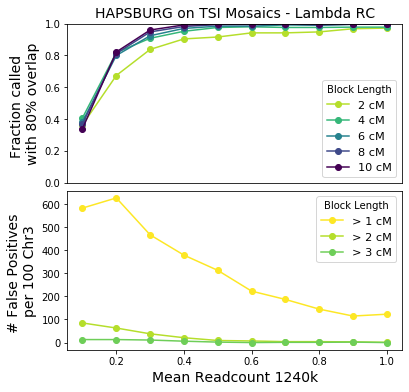

In [25]:
title = "HAPSBURG on TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", xlabel="Mean Readcount 1240k", xscale="linear", leg_loc="lower right", leg_loc1="upper right")

### Plot downsampled Lambda Readcounts (0.1-1.0x) for TSI Mosaics (allref with full 1000 Genome Haplotypes)

In [5]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "allref/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=False)

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 51.7 s, sys: 3.41 s, total: 55.1 s
Wall time: 3min 43s


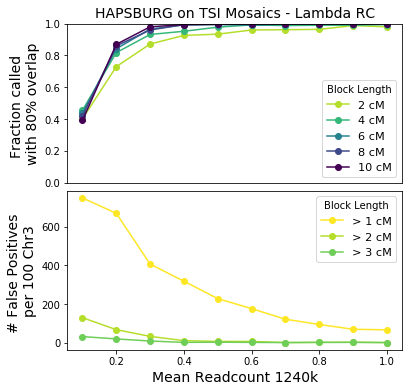

In [6]:
title = "HAPSBURG on TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", xlabel="Mean Readcount 1240k", xscale="linear", leg_loc="lower right", leg_loc1="upper right")

## Plot **bcftools** Lambda Readcount Curves

### 0.1-1.0x Coverage

In [27]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "bcftools/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", output_prefix=output_prefix, rd_digs=False)  # or rc for normal rc

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 53.7 s, sys: 2.76 s, total: 56.4 s
Wall time: 3min 52s


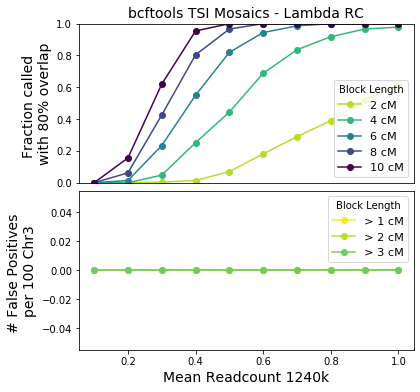

In [28]:
title = "bcftools TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", xlabel="Mean Readcount 1240k", xscale="linear", leg_loc="lower right", leg_loc1="upper right")

In [8]:
%%time
rc_vec = np.linspace(0.1, 1, 10)

bl_lens = [2, 4, 6, 8, 10]
pw_lens = [1, 2, 3]
base_path="./Simulated/1000G_Mosaic/TSI5/"
output_prefix = "bcftools100/" # e001/ mmr95/ ROH385/

fps, powers = load_fp_powers_rc(base_path, rc_vec, bl_lens, pw_lens, rc_string = "lambda_rc", 
                                output_prefix=output_prefix, rd_digs=False)

Loading data for mean RC: 0.1 x
Loading data for mean RC: 0.2 x
Loading data for mean RC: 0.30000000000000004 x
Loading data for mean RC: 0.4 x
Loading data for mean RC: 0.5 x
Loading data for mean RC: 0.6 x
Loading data for mean RC: 0.7000000000000001 x
Loading data for mean RC: 0.8 x
Loading data for mean RC: 0.9 x
Loading data for mean RC: 1.0 x
Successfully loaded complete data!
CPU times: user 46.3 s, sys: 2.29 s, total: 48.6 s
Wall time: 1min 40s


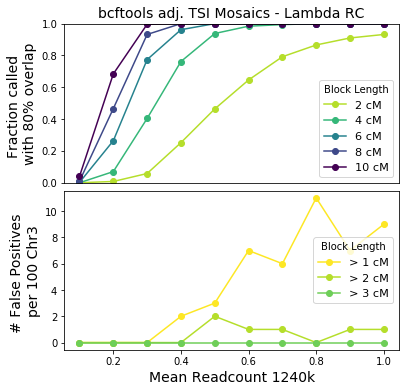

In [10]:
title = "bcftools adj. TSI Mosaics - Lambda RC"
plot_fp_power_errors(rc_vec, pw_lens, bl_lens, fps, powers, title=title, 
                     savepath="", xlabel="Mean Readcount 1240k", xscale="linear", leg_loc="lower right", leg_loc1="center right")

### 1.0x to 10x
Maybe not needed anymore because of accurate performance on 1.0x data

# Plot FP rate along genome

In [32]:
output_prefix = ""   #"ROHin100/" #"ROHin50/" prefix_out = "e01rohin300/" diploidGT/
#mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/lambda_rc2.0/"
mosaic_folder = "./Simulated/1000G_Mosaic/TSI5/"
bl_lens = [2, 4, 6, 8, 10]
bl_focus = 0 # To show background rate
ch=3
nr_iid=100

roh = Summary_ROH_Calls(mosaic_folder=mosaic_folder, ch=ch, nr_iid = nr_iid, blen_cm = bl_focus, output_prefix = output_prefix, output=1)
df_call_fp = roh.collect_fp_df()

### Load the Map Positions
path_map = "./Simulated/1000G_Mosaic/TSI5/ch3_0cm/output/iid0/chr3/map.csv"
df_map = pd.read_csv(path_map, sep=",", header=None)  # Load the Meta File
map_pos = df_map[0].values

In [33]:
starts = df_call_fp["StartM"].values
ends = df_call_fp["EndM"].values

### Create the Binned Statistic
bins10 = np.arange(min(map_pos), max(map_pos), step=0.005)  # 0.1 cM Bins
counts = np.zeros(len(bins10), dtype="int")

for i in range(len(starts)):
    i1 = np.searchsorted(bins10, starts[i])
    i2 = np.searchsorted(bins10, ends[i])
    counts[i1:i2] = counts[i1:i2]+1 # Add one to the counter

### Plot Counts False Positives and SNP density


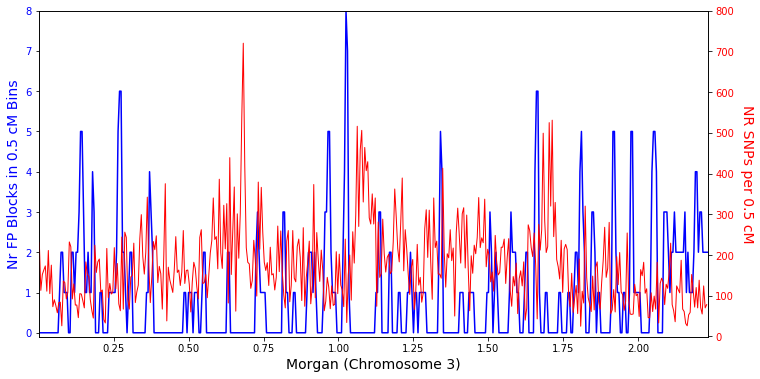

In [34]:
fs = 14

plt.figure(figsize=(12,6))
c1 = "blue"
c2 = "red"

ax = plt.gca()
ax.set_xlim((min(map_pos), max(map_pos)))
ax.plot(bins10, counts, color=c1)
ax.tick_params(axis='y', labelcolor=c1)
ax.set_ylim([-0.1, 8])
ax.set_ylabel("Nr FP Blocks in 0.5 cM Bins", fontsize=fs, color=c1)

ax1 = ax.twinx()  # instantiate a second axes that shares the same x-axis
n, b = np.histogram(map_pos, bins = bins10)
x = (b[1:] + b[:-1]) / 2

ax1.plot(x, n, color=c2, linewidth=1.0)
ax1.tick_params(axis='y', labelcolor=c2)
ax1.set_ylim([-1, 800])
ax1.set_ylabel("NR SNPs per 0.5 cM", color=c2, rotation=270, labelpad=fs*1.4, fontsize=fs)


ax.set_xlabel("Morgan (Chromosome 3)", fontsize=fs)
plt.show()

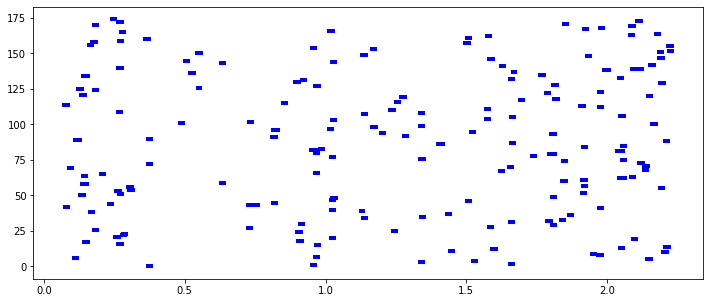

In [35]:
plt.figure(figsize=(12,5))
for i in range(len(df_call_fp)):
    plt.plot([starts[i], ends[i]], [i,i], linewidth=4, color="blue")
plt.show()

# Area 51